# AI and Finance Project
## Objective and team composition


Tommaso Menti VR504908 \
Simone Murari VR502957 \
Masud Talukdar VR510632

The goal of our project is to develop a reinforcement learning agent that is able to open long and short positions in order to maximize the profit on the IVV S&P500 ETF. \
The main idea about this is that our agent can find some common 'patterns' in the stocks market trends and determine the optimal timing for specific actions.
We want to optimize the percentage of successful positions.
It is considered a successful position a position where a profit is made.
In order to evaluate this we look at the success rate: \
Success rate = Positive positions / Total number of positions


In [16]:
# Importing the libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import warnings

# Set random seed for reproducibility
seed = 21
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Data import, analysis and preparation


(978037, 6)


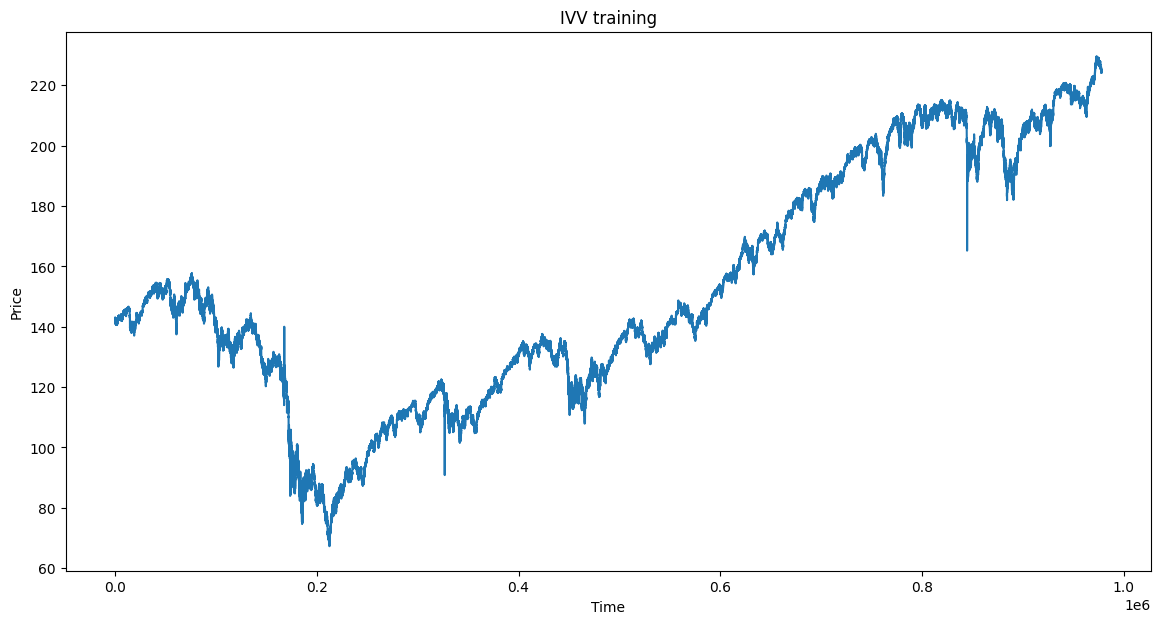

In [17]:
df_train = pd.read_csv('data/IVV_1m_training.csv')
print(df_train.shape)
plt.figure(figsize=(14, 7))
plt.plot(df_train['Close'])
plt.title('IVV training')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [18]:
df_train = df_train.sort_values('DateTime')
df_train = df_train.reset_index(drop=True)
df_train['DateTime'] = pd.to_datetime(df_train['DateTime'])

# Add the prediction column obtained using the LSTM model to the training data
df_train_pred = pd.read_csv('lstm/train_next_close_prediction.csv')

df_train

,DateTime,Low,Volume,Open,High,Close
0,2007-01-03 14:30:00+00:00,142.10,133200,142.530,142.530,142.260
1,2007-01-03 14:31:00+00:00,142.28,4400,142.280,142.450,142.450
2,2007-01-03 14:32:00+00:00,142.41,3500,142.420,142.470,142.470
3,2007-01-03 14:33:00+00:00,142.52,300,142.540,142.540,142.538
4,2007-01-03 14:34:00+00:00,142.46,3400,142.519,142.519,142.460
...,...,...,...,...,...,...
978032,2016-12-30 20:55:00+00:00,224.25,73404,224.280,224.450,224.450
978033,2016-12-30 20:56:00+00:00,224.37,55152,224.440,224.490,224.450
978034,2016-12-30 20:57:00+00:00,224.45,104419,224.450,224.710,224.670
978035,2016-12-30 20:58:00+00:00,224.63,248625,224.670,224.800,224.760


In [19]:
# Remove the first rows from the training data as the prediction is not available for these rows and add the prediction column to the training data
df_train = df_train.iloc[df_train.shape[0] - df_train_pred.shape[0]:]
df_train['Prediction'] = df_train_pred.iloc[:, 0].values
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)
df_train['Low'] = df_train['Low'].astype(np.float32)
df_train['Volume'] = df_train['Volume'].astype(np.float32)
df_train['Open'] = df_train['Open'].astype(np.float32)
df_train['High'] = df_train['High'].astype(np.float32)
df_train['Close'] = df_train['Close'].astype(np.float32)
df_train['Prediction'] = df_train['Prediction'].astype(np.float32)
df_train = df_train.tail(50000)
df_train = df_train.reset_index(drop=True)
df_train

,DateTime,Low,Volume,Open,High,Close,Prediction
0,2007-01-03 15:31:00+00:00,143.039993,7500.0,143.039993,143.070007,143.039993,143.119995
1,2007-01-03 15:32:00+00:00,143.029999,1000.0,143.070007,143.070007,143.039993,143.100006
2,2007-01-03 15:33:00+00:00,142.979996,500.0,143.009995,143.009995,142.979996,143.139999
3,2007-01-03 15:34:00+00:00,142.992004,500.0,142.992004,143.009995,143.007996,143.149994
4,2007-01-03 15:35:00+00:00,143.009995,2200.0,143.009995,143.029999,143.009995,143.100006
...,...,...,...,...,...,...,...
977971,2016-12-30 20:55:00+00:00,224.250000,73404.0,224.279999,224.449997,224.449997,224.470001
977972,2016-12-30 20:56:00+00:00,224.369995,55152.0,224.440002,224.490005,224.449997,224.490005
977973,2016-12-30 20:57:00+00:00,224.449997,104419.0,224.449997,224.710007,224.669998,224.630005
977974,2016-12-30 20:58:00+00:00,224.630005,248625.0,224.669998,224.800003,224.759995,224.630005


(292620, 6)


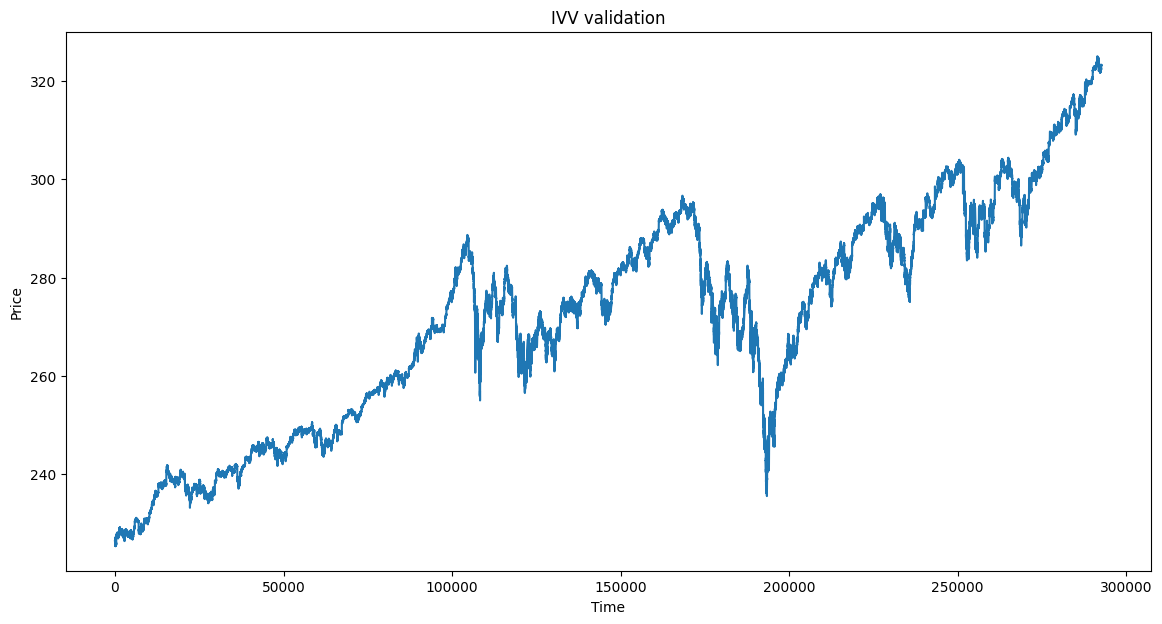

In [20]:
# Now we do the same for the validation data
df_val = pd.read_csv('data/IVV_1m_validation.csv')
print(df_val.shape)
plt.figure(figsize=(14, 7))
plt.plot(df_val['Close'])
plt.title('IVV validation')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [21]:
df_val = df_val.sort_values('DateTime')
df_val = df_val.reset_index(drop=True)
df_val['DateTime'] = pd.to_datetime(df_val['DateTime'])

df_val_pred = pd.read_csv('lstm/val_next_close_prediction.csv')

df_val

,DateTime,Low,Volume,Open,High,Close
0,2017-01-03 14:30:00+00:00,226.3100,238433,226.4000,226.490,226.3200
1,2017-01-03 14:31:00+00:00,226.1900,20058,226.3200,226.390,226.2100
2,2017-01-03 14:32:00+00:00,226.2200,15368,226.2200,226.270,226.2499
3,2017-01-03 14:33:00+00:00,226.2210,12309,226.2499,226.367,226.3600
4,2017-01-03 14:34:00+00:00,226.3654,18264,226.3654,226.510,226.4600
...,...,...,...,...,...,...
292615,2019-12-31 20:55:00+00:00,323.2199,19425,323.2200,323.350,323.3400
292616,2019-12-31 20:56:00+00:00,323.1900,23830,323.3300,323.350,323.1900
292617,2019-12-31 20:57:00+00:00,323.0700,57869,323.1700,323.200,323.1000
292618,2019-12-31 20:58:00+00:00,323.0400,78933,323.1250,323.160,323.1000


In [22]:
df_val = df_val.iloc[df_val.shape[0] - df_val_pred.shape[0]:]
df_val['Prediction'] = df_val_pred.iloc[:, 0].values
df_val = df_val.dropna()
df_val = df_val.reset_index(drop=True)
df_val['Low'] = df_val['Low'].astype(np.float32)
df_val['Volume'] = df_val['Volume'].astype(np.float32)
df_val['Open'] = df_val['Open'].astype(np.float32)
df_val['High'] = df_val['High'].astype(np.float32)
df_val['Close'] = df_val['Close'].astype(np.float32)
df_val['Prediction'] = df_val['Prediction'].astype(np.float32)
df_val

,DateTime,Low,Volume,Open,High,Close,Prediction
0,2017-01-03 15:31:00+00:00,226.919998,6879.0,227.000000,227.000000,226.919998,227.100006
1,2017-01-03 15:32:00+00:00,226.850006,71755.0,226.899994,226.910004,226.850006,227.190002
2,2017-01-03 15:33:00+00:00,226.820007,3715.0,226.839996,226.869995,226.820007,227.130005
3,2017-01-03 15:34:00+00:00,226.789993,7357.0,226.809998,226.822998,226.799393,227.080002
4,2017-01-03 15:35:00+00:00,226.706299,32904.0,226.810104,226.820007,226.729996,227.059998
...,...,...,...,...,...,...,...
292554,2019-12-31 20:55:00+00:00,323.219910,19425.0,323.220001,323.350006,323.339996,319.950012
292555,2019-12-31 20:56:00+00:00,323.190002,23830.0,323.329987,323.350006,323.190002,320.089996
292556,2019-12-31 20:57:00+00:00,323.070007,57869.0,323.170013,323.200012,323.100006,320.140015
292557,2019-12-31 20:58:00+00:00,323.040009,78933.0,323.125000,323.160004,323.100006,320.079987


In [23]:
# # TO DELETE
# df_train = df_train[960000:]
# df_train = df_train.reset_index(drop=True)
# df_train

In [24]:
# TO DELETE
# df_val = df_val[:6212]
# df_val = df_val.reset_index(drop=True)
# df_val

## Method and assumptions

Our agent has 2 different strategies: 
- Exploit long positions: at first it buys some shares and later it sells them. The goal is to sell at a higher price than the purchase price of the stock.
- Exploit short positions: at first it borrows some shares and later it buys them back. The goal is to buy back at a lower price than the one when it borrowed the shares.

In order to do so the agent considers the data from the OHLCV values of the last 5 minutes, for example the agent decides the amount of shares it wants to trade based on the Volume of the ETF being traded.
The agent gets a positive reward if the balance increases and a negative reward if it wasn't a useful action. 
We want our agent to perform between 2 and 8 trades per day, so it gets a negative reward if the number of trades does not respect these conditions.
Lastly we want to avoid any trade being open overnight, so the agent is penalized if some trades are forcibly closed at the end of the trading day.


Our trading agent starts with a balance of 10000.\
The window size defines the amount of minutes the agent looks back in order to get its state, we set this parameter to 5. \
We also set a trading fee equal to 0.001, this fee is applied to every transaction executed by the agent. \
The agent can open only one position at a time, e.g.: he can open a long position and "expand" it by buying other shares on top of it but he can not open a short position at the same time, it must close the long one first. \
Lastly, we do not consider market liquidity and market impact: whenever the agent wants to perform an action it is immediately executed and the actions of the agent have no effect on the market.


## Training and validation

In [25]:
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
INITIAL_ACCOUNT_BALANCE = 10000


class StockTradingEnv():
    """A stock trading environment"""

    def __init__(self, df):
        self.df = df
        self.datetime = df['DateTime']
        self.current_step = 5
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.balance_at_start_of_position = 0
        self.shares_held = 0
        self.trading_fee = 0.001
        self.day = 1
        self.num_trades = 0
        self.num_positions = 0
        self.successful_positions = 0
        self.history = {
            'buy': [],
            'sell': []
        }
        self.action_space = 3
        self.observation_space = self.get_state().shape
        
    def get_state(self):
        # Get the data points for the last 5 minutes and scale to between 0-1
        frame = np.array([
            self.df.loc[self.current_step - 5: self.current_step - 1 , 'Open'].values / self.df['Open'].max(),
            self.df.loc[self.current_step - 5: self.current_step - 1, 'High'].values / self.df['High'].max(),
            self.df.loc[self.current_step - 5: self.current_step - 1, 'Low'].values / self.df['Low'].max(),
            self.df.loc[self.current_step - 5: self.current_step - 1, 'Close'].values / self.df['Close'].max(),
            self.df.loc[self.current_step - 5: self.current_step - 1, 'Volume'].values / self.df['Volume'].max()
        ])

        # Append additional data and scale each value to between 0-1
        other = np.array([
            self.balance / MAX_ACCOUNT_BALANCE,
            self.net_worth / MAX_ACCOUNT_BALANCE,
            self.shares_held / MAX_NUM_SHARES,
            self.successful_positions / self.num_positions if self.num_positions > 0 else 0,
            self.df.loc[self.current_step, 'Prediction'] / self.df['Prediction'].max()
        ])

        obs = np.append(frame, [other], axis=0)
        obs = obs.reshape(1, -1)
        obs = obs.astype(np.float32)
        return obs

    def _take_action(self, action):

        reward = 0
        profit = 0
        current_price = self.df.loc[self.current_step, 'Close']

        # Set the amount to be bought/sold based on the volume of the last 5 minutes
        amount = np.mean(self.df.loc[self.current_step - 5: self.current_step - 1, 'Volume'].values / self.df['Volume'].max())
        amount = min(np.round(amount * 50, 2), 1)

        if self.net_worth > INITIAL_ACCOUNT_BALANCE and amount >= 0.5:
            amount = 0.25

        if self.num_trades / self.day >= 8:
            action = 0
            reward = 0

        if self.shares_held == 0 and action == 1 or action == 2:
            reward = 10
        elif self.shares_held > 0 and action == 2:
            reward = 10
        elif self.shares_held < 0 and action == 1:
            reward = 10

        if self.current_step + 1 != len(self.df):
            if self.datetime[self.current_step + 1].day != self.datetime[self.current_step].day:
                # If the next day is a new day, sell/buy all shares
                if self.shares_held != 0:
                    if self.shares_held > 0:
                        if action != 2:
                            reward = -5
                        action = 2
                        amount = 1
                    else:
                        if action != 1:
                            reward = -5
                        action = 1
                        amount = 1     
                else:
                    action = 0
                    reward = 0
        else:
            if self.shares_held != 0:
                if self.shares_held > 0:
                    if action != 2:
                        reward = -5
                    action = 2
                    amount = 1
                else:
                    if action != 1:
                        reward = -5
                    action = 1
                    amount = 1
            else:
                action = 0
                reward = 0

        if action == 1:
            # Buy amount % of balance in shares
            self.history['sell'].append(None)
            if self.shares_held >= 0:
                total_possible = self.balance / (current_price * (1 + self.trading_fee))
                shares_bought = int(total_possible * amount)
                if shares_bought > 0:
                    cost = shares_bought * current_price * (1 + self.trading_fee)
                    self.balance_at_start_of_position = self.balance
                    self.balance -= cost
                    self.shares_held += shares_bought
                    self.num_trades += 1
                    self.history['buy'].append(current_price)
                else:
                    # reward -= 1
                    self.history['buy'].append(None)
            else:
                # Cover short
                shares_bought = int(-self.shares_held * amount)
                if shares_bought > 0:
                    cost = shares_bought * current_price * (1 + self.trading_fee)
                    self.balance -= cost
                    self.shares_held += shares_bought
                    self.num_trades += 1
                    self.history['buy'].append(current_price)
                    if self.shares_held == 0:
                        self.num_positions += 1
                        profit = self.balance - self.balance_at_start_of_position
                        if profit > 0:
                            self.successful_positions += 1
                else:
                    # reward -= 1
                    self.history['buy'].append(None)
        elif action == 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.history['buy'].append(None)
            if shares_sold > 0:
                self.balance += shares_sold * current_price * (1 - self.trading_fee)
                self.shares_held -= shares_sold
                self.num_trades += 1
                self.history['sell'].append(current_price)
                if self.shares_held == 0:
                    self.num_positions += 1
                    profit = self.balance - self.balance_at_start_of_position
                    if profit > 0:
                        self.successful_positions += 1
            elif self.shares_held <= 0:
                # Start short
                total_possible = self.balance / (current_price * (1 + self.trading_fee))
                shares_borrowed = int(total_possible * amount)
                if shares_borrowed > 0:
                    self.shares_held -= shares_borrowed
                    self.balance_at_start_of_position = self.balance
                    self.balance += shares_borrowed * current_price * (1 - self.trading_fee)
                    self.num_trades += 1
                    self.history['sell'].append(current_price)
                    reward -= 2 # Shorting is risky
                else:
                    # reward -= 1
                    self.history['sell'].append(None)
        elif action == 0:
            self.history['sell'].append(None)
            self.history['buy'].append(None)

        self.net_worth = self.balance + self.shares_held * current_price

        if action == 0 and self.num_trades == 0:
            reward -= 5
        elif action == 0 and round(self.num_trades / self.day, 2) < 2:
            reward -= 5
        elif self.shares_held == 0 and action != 0:
            if profit == 0:
                reward += 5
            if profit > 0 and self.balance - INITIAL_ACCOUNT_BALANCE < 0:
                reward += profit
            elif self.balance - INITIAL_ACCOUNT_BALANCE > 0:
                reward += 5

        reward += (self.successful_positions / self.num_positions) * 10 if self.num_positions > 0 else 0

        return reward
    
    def step(self, action):

        reward = self._take_action(action)

        self.current_step += 1

        if self.current_step < len(self.df):
            if self.datetime[self.current_step].day != self.datetime[self.current_step - 1].day:
                self.day += 1


        if self.net_worth <= 0:
            done = True
            reward -= 1000
        elif self.current_step >= self.df.shape[0]:
            done = True
        else:
            done = False

        if not done:
            obs = self.get_state()
        else:
            obs = None

        return obs, reward, done

    def reset(self, step=5):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.balance_at_start_of_position = 0
        self.shares_held = 0
        self.num_trades = 0
        self.num_positions = 0
        self.successful_positions = 0
        self.current_step = step
        self.history = {
            'buy': [],
            'sell': []
        }
        self.day = 1
        return self.get_state()

In [26]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [27]:
class DQN(nn.Module):
	def __init__(self, state_size, action_size):
		super(DQN, self).__init__()
		self.main = nn.Sequential(
			nn.Linear(state_size, 64),
			nn.LeakyReLU(0.01, inplace=True),
			nn.Linear(64, 32),
			nn.LeakyReLU(0.01, inplace=True),
			nn.Linear(32, 8),
			nn.LeakyReLU(0.01, inplace=True),
			nn.Linear(8, action_size),
		)
	
	def forward(self, input):
		return self.main(input)

In [28]:
def training_loop(env, neural_net, updateRule, eps=1.0, episodes=100, eps_decay=0.99995, eps_min=0.01):

	# Initialize the optimizer 
	optimizer = optim.SGD(neural_net.parameters(), lr=0.05)
	rewards_list, memory_buffer = [], ReplayMemory(10000)
	averaged_rewards = []
	episodes_stats = []
	end_of_episode_step = 5
	
	starts = np.arange(0, len(df_train) - 225000, 225000)
	starts = [val for val in starts for _ in (0, 1)]
	starts.append(starts[-1])
	starts.append(starts[-1])
	
	for ep in tqdm(range(episodes), desc='Episodes'):
		action_count = [0, 0, 0]

		# Sample a subset of the training data
		start = starts[ep % len(starts)]
		if start != starts[-1]:
			sample_df = df_train.iloc[start:start + 225000]
		else:
			sample_df = df_train.iloc[start:]
		sample_df = sample_df.reset_index(drop=True)
		env.df = sample_df
		logs = [env.current_step, int(env.df.shape[0] * 0.25), int(env.df.shape[0] * 0.5), int(env.df.shape[0] * 0.75), int(env.df.shape[0]) - 1]

		state = env.reset(end_of_episode_step)
		state = torch.tensor(state, device=device, dtype=torch.float32)
		ep_reward = 0
		logs = [0, int(env.df.shape[0] * 0.25), int(env.df.shape[0] * 0.5), int(env.df.shape[0] * 0.75), env.df.shape[0] - 1]
		for i in tqdm(range(env.df.shape[0]), desc='Steps', leave=False):
			if np.random.rand() < eps:
				action = np.random.choice([0, 1, 2]).astype(np.int64)
			else:
				with torch.no_grad():
					action = torch.argmax(neural_net(state)).item()
					action_count[action] += 1
			eps = max(eps * eps_decay, eps_min)

			next_state, reward, done = env.step(action)
			if int(env.balance) <= int(env.df.Close.min()) and env.shares_held == 0:
				done = True
				next_state = None
				reward -= 1000

			if next_state is not None:
				next_state = torch.tensor(next_state, device=device, dtype=torch.float32)
			memory_buffer.push(state, action, next_state, reward, torch.tensor([done], device=device))
			ep_reward += reward

			if i in logs or done:
				profit = env.net_worth - INITIAL_ACCOUNT_BALANCE

				if done:
					print('----DONE----')
				if done and env.net_worth <= 0:
					print('----BANKRUPT----')
				print(f'Day: {env.day}')
				print(f'Current step: {env.current_step}')
				print(f'Episodes reward: {ep_reward}')
				print(f'Profit: {profit}')
				print(f'Net Worth: {env.net_worth}')
				print(f'Balance: {env.balance}')
				print(f'Shares held: {env.shares_held}')
				print(f'Trades: {env.num_trades}')
				print(f'Trades per day: {env.num_trades / env.day}')
				print(f'Action: {action}, reward: {reward}')
				print(f'Epsilon: {eps}')
				print(f'Num positions: {env.num_positions}')
				print(f'Successful positions: {env.successful_positions}')
				print(f'Actions: {action_count}')
				print(f'Min close: {env.df.Close.min()}')
				print('\n')

			# Perform the actual training
			updateRule(neural_net, memory_buffer, optimizer)
				
			if done:
				if env.current_step < len(env.df) - 1:
					print(env.current_step, len(env.df) - 1)
					end_of_episode_step = env.current_step
				else:
					end_of_episode_step = 5
				break

			# Update the current state
			state = next_state

		# Update the reward list to return
		rewards_list.append(ep_reward)
		averaged_rewards.append(np.mean(rewards_list))
		print( f"episode {ep+1:2d}: mean reward: {averaged_rewards[-1]:3.2f}, epsilon: {eps}" )
		episodes_stats.append([ep, ep_reward, env.net_worth, env.balance, env.shares_held, env.num_trades, env.num_trades / env.day, profit, env.history['buy'], env.history['sell']])

	return averaged_rewards, episodes_stats

In [29]:
def DQNupdate(neural_net, memory, optimizer, batch_size=32, gamma=0.99):

	if len(memory) < 1000:
		return
	
	# Sample a random batch of transitions
	transitions = memory.sample(batch_size)
	batch = Transition(*zip(*transitions))
	
	done_batch = torch.cat(batch.done).to(device)
	non_final_mask = ~done_batch
	non_final_next_states = torch.cat([s for s, d in zip(batch.next_state, batch.done) if not d])
	state_batch = torch.cat(batch.state).to(device)
	action_batch = torch.tensor(batch.action, device=device).unsqueeze(1)
	reward_batch = torch.tensor(batch.reward, device=device)

	# Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
	state_action_values = neural_net(state_batch).gather(1, action_batch)

	# Compute V(s_{t+1}) for all next states.
	next_state_values = torch.zeros(batch_size, device=device)
	next_state_values[non_final_mask] = neural_net(non_final_next_states).max(1)[0].detach()

	# Compute the expected Q values
	expected_state_action_values = (next_state_values * gamma) + reward_batch

	# Compute Huber loss
	loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1)).to(device)

	# Optimize the model
	optimizer.zero_grad()
	loss.backward()
	for param in neural_net.parameters():
		param.grad.data.clamp_(-1, 1)
	optimizer.step()

In [30]:
train_env = StockTradingEnv(df_train)
action_space = train_env.action_space
state_space = train_env.observation_space[1]
neural_net = DQN(state_space, action_space).to(device)
neural_net.train()
episodes = 10
eps = 1
eps_min = 0.01
eps_decay = (eps_min / eps) ** (1 / (train_env.df.shape[0] * (1.5)))
averaged_rewards_training, episodes_stats_training = training_loop(train_env, neural_net, DQNupdate, eps=eps, episodes=episodes, eps_decay=eps_decay, eps_min=eps_min)

torch.save(neural_net.state_dict(), 'DQN_trained_model.pth')

Episodes:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/225000 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: -5
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 0, reward: -5
Epsilon: 0.9999968607525763
Num positions: 0
Successful positions: 0
Actions: [0, 0, 0]
Min close: 67.25


Day: 145
Current step: 56256
Episodes reward: 465002.8492854424
Profit: -831.3322433776138
Net Worth: 9168.667756622386
Balance: 3275.067903106761
Shares held: 40
Trades: 1160
Trades per day: 8.0
Action: 0, reward: 5.0
Epsilon: 0.8381266267544504
Num positions: 144
Successful positions: 72
Actions: [1592, 1705, 1450]
Min close: 67.25


Day: 291
Current step: 112506
Episodes reward: 962083.7346488877
Profit: -4113.15278380565
Net Worth: 5886.84721619435
Balance: 7814.227190559584
Shares held: -14
Trades: 2328
Trades per day: 8.0
Action: 2, reward: 4.813559322033899
Epsilon: 0.702458447665671
Num positions: 295
Successful positions: 142
Actions: [6097, 5361, 6231]
Min close: 67.25


Day: 435
Current step: 168756
Episodes reward: 

Steps:   0%|          | 0/225000 [00:00<?, ?it/s]

Day: 1
Current step: 175432
Episodes reward: 10
Profit: -7.112839721678029
Net Worth: 9992.887160278322
Balance: 2880.0474385986336
Shares held: 76
Trades: 1
Trades per day: 1.0
Action: 1, reward: 10
Epsilon: 0.5765405392173523
Num positions: 0
Successful positions: 0
Actions: [0, 0, 0]
Min close: 67.25


----DONE----
----BANKRUPT----
Day: 7
Current step: 177538
Episodes reward: 24550.563736623033
Profit: -12496.927098739601
Net Worth: -2496.927098739601
Balance: 397664.08635951235
Shares held: -4517
Trades: 56
Trades per day: 8.0
Action: 1, reward: -993.3333333333334
Epsilon: 0.5727414489041266
Num positions: 6
Successful positions: 4
Actions: [417, 112, 370]
Min close: 67.25


177538 224999
episode  2: mean reward: 731819.05, epsilon: 0.5727414489041266


Steps:   0%|          | 0/225000 [00:00<?, ?it/s]

Day: 1
Current step: 177539
Episodes reward: -5
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 0, reward: -5
Epsilon: 0.5727396509270087
Num positions: 0
Successful positions: 0
Actions: [0, 0, 0]
Min close: 83.87000274658203


----DONE----
Day: 123
Current step: 225000
Episodes reward: 273766.23050765594
Profit: -1297.5243010329796
Net Worth: 8702.47569896702
Balance: 8702.47569896702
Shares held: 0
Trades: 985
Trades per day: 8.008130081300813
Action: 0, reward: -1.4000000000000004
Epsilon: 0.4934587142177301
Num positions: 125
Successful positions: 45
Actions: [8132, 6259, 7884]
Min close: 83.87000274658203


episode  3: mean reward: 579134.77, epsilon: 0.4934587142177301


Steps:   0%|          | 0/225000 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: 10
Profit: -3.2683800811755646
Net Worth: 9996.731619918824
Balance: 6728.351538742066
Shares held: 38
Trades: 1
Trades per day: 1.0
Action: 1, reward: 10
Epsilon: 0.4934571651287328
Num positions: 0
Successful positions: 0
Actions: [0, 0, 0]
Min close: 83.87000274658203


Day: 145
Current step: 56256
Episodes reward: 434300.23166878993
Profit: -2212.7540362929503
Net Worth: 7787.24596370705
Balance: 9126.805930748065
Shares held: -12
Trades: 1160
Trades per day: 8.0
Action: 1, reward: 4.758620689655173
Epsilon: 0.41358088758989325
Num positions: 145
Successful positions: 69
Actions: [11829, 8308, 10676]
Min close: 83.87000274658203


Day: 291
Current step: 112506
Episodes reward: 888700.3881479588
Profit: -3097.7587110899567
Net Worth: 6902.241288910043
Balance: 11843.881181488168
Shares held: -44
Trades: 2328
Trades per day: 8.0
Action: 2, reward: 5.017182130584192
Epsilon: 0.3466342423764831
Num positions: 291
Successful positions: 146
Actions

Steps:   0%|          | 0/225000 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: 8
Profit: -2.0919600219731365
Net Worth: 9997.908039978027
Balance: 12089.868061950683
Shares held: -18
Trades: 1
Trades per day: 1.0
Action: 2, reward: 8
Epsilon: 0.24350073822594653
Num positions: 0
Successful positions: 0
Actions: [0, 0, 1]
Min close: 107.87000274658203


Day: 145
Current step: 56256
Episodes reward: 532750.2714862997
Profit: -1808.8913214034337
Net Worth: 8191.108678596566
Balance: 5580.318609016488
Shares held: 19
Trades: 1160
Trades per day: 8.0
Action: 0, reward: 6.551724137931034
Epsilon: 0.20408509301513456
Num positions: 145
Successful positions: 95
Actions: [10710, 20026, 13068]
Min close: 107.87000274658203


Day: 291
Current step: 112506
Episodes reward: 1154589.638732192
Profit: -3517.129846229397
Net Worth: 6482.870153770603
Balance: 7496.4519103624
Shares held: -7
Trades: 2328
Trades per day: 8.0
Action: 2, reward: 14.164383561643836
Epsilon: 0.17104968754693475
Num positions: 292
Successful positions: 180
Actions

Steps:   0%|          | 0/225000 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: 10
Profit: -2.0919600219713175
Net Worth: 9997.908039978029
Balance: 7905.9480180053715
Shares held: 18
Trades: 1
Trades per day: 1.0
Action: 1, reward: 10
Epsilon: 0.1201575611960405
Num positions: 0
Successful positions: 0
Actions: [0, 1, 0]
Min close: 107.87000274658203


Day: 145
Current step: 56256
Episodes reward: 442629.663763393
Profit: -3057.199382278377
Net Worth: 6942.800617721623
Balance: 9553.590687301701
Shares held: -19
Trades: 1160
Trades per day: 8.0
Action: 2, reward: 5.337837837837838
Epsilon: 0.10070756759025022
Num positions: 148
Successful positions: 79
Actions: [13381, 19406, 17221]
Min close: 107.87000274658203


Day: 291
Current step: 112506
Episodes reward: 1001571.5676081344
Profit: -3334.51416867041
Net Worth: 6665.48583132959
Balance: 5651.904074737793
Shares held: 7
Trades: 2328
Trades per day: 8.0
Action: 0, reward: 5.850340136054422
Epsilon: 0.08440595888425026
Num positions: 294
Successful positions: 172
Actions: 

Steps:   0%|          | 0/302976 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: 15
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 1, reward: 15
Epsilon: 0.05929279565133378
Num positions: 0
Successful positions: 0
Actions: [0, 1, 0]
Min close: 165.22000122070312


Day: 195
Current step: 75750
Episodes reward: 875469.9602639992
Profit: -868.044675094583
Net Worth: 9131.955324905417
Balance: 7715.0153377228
Shares held: 7
Trades: 1560
Trades per day: 8.0
Action: 1, reward: 7.474226804123711
Epsilon: 0.04674504583521547
Num positions: 194
Successful positions: 145
Actions: [17651, 35050, 19046]
Min close: 165.22000122070312


Day: 391
Current step: 151494
Episodes reward: 1754479.4848004312
Profit: -1990.4199267577078
Net Worth: 8009.580073242292
Balance: 9705.340083007917
Shares held: -8
Trades: 3128
Trades per day: 8.0
Action: 2, reward: 7.282051282051282
Epsilon: 0.03685269493760697
Num positions: 390
Successful positions: 284
Actions: [35676, 69789, 38921]
Min close: 165.2

Steps:   0%|          | 0/302976 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: 15
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 1, reward: 15
Epsilon: 0.022905690764569536
Num positions: 0
Successful positions: 0
Actions: [0, 1, 0]
Min close: 165.22000122070312


Day: 195
Current step: 75750
Episodes reward: 630756.635222233
Profit: -1263.3498602142026
Net Worth: 8736.650139785797
Balance: 7319.710152603179
Shares held: 7
Trades: 1560
Trades per day: 8.0
Action: 2, reward: 4.948979591836735
Epsilon: 0.01805830797679699
Num positions: 196
Successful positions: 97
Actions: [22641, 25869, 25707]
Min close: 165.22000122070312


Day: 391
Current step: 151494
Episodes reward: 1372374.7081098913
Profit: -2476.979616546557
Net Worth: 7523.020383453443
Balance: 4979.380368805006
Shares held: 12
Trades: 3128
Trades per day: 8.0
Action: 1, reward: 5.994897959183674
Epsilon: 0.01423674537199568
Num positions: 392
Successful positions: 235
Actions: [43176, 62317, 43249]
Min close: 165

Steps:   0%|          | 0/302976 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: -5
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 0, reward: -5
Epsilon: 0.01
Num positions: 0
Successful positions: 0
Actions: [1, 0, 0]
Min close: 165.22000122070312


Day: 195
Current step: 75750
Episodes reward: 832346.1650140954
Profit: -712.0570073699473
Net Worth: 9287.942992630053
Balance: 7871.0030054474355
Shares held: 7
Trades: 1560
Trades per day: 8.0
Action: 2, reward: 7.00507614213198
Epsilon: 0.01
Num positions: 197
Successful positions: 138
Actions: [27353, 32151, 15476]
Min close: 165.22000122070312


Day: 391
Current step: 151494
Episodes reward: 1715538.9082813398
Profit: -2134.1078708952855
Net Worth: 7865.8921291047145
Balance: 5746.192116897683
Shares held: 10
Trades: 3128
Trades per day: 8.0
Action: 1, reward: 7.150127226463105
Epsilon: 0.01
Num positions: 393
Successful positions: 281
Actions: [50371, 66033, 33558]
Min close: 165.22000122070312


Day: 586
Current step: 22

Steps:   0%|          | 0/302976 [00:00<?, ?it/s]

Day: 1
Current step: 6
Episodes reward: 15
Profit: 0.0
Net Worth: 10000.0
Balance: 10000
Shares held: 0
Trades: 0
Trades per day: 0.0
Action: 2, reward: 15
Epsilon: 0.01
Num positions: 0
Successful positions: 0
Actions: [0, 0, 1]
Min close: 165.22000122070312


Day: 195
Current step: 75750
Episodes reward: 567021.6416695088
Profit: -677.0975079192722
Net Worth: 9322.902492080728
Balance: 7905.962504898111
Shares held: 7
Trades: 1560
Trades per day: 8.0
Action: 1, reward: 5.6701030927835046
Epsilon: 0.01
Num positions: 194
Successful positions: 110
Actions: [19012, 31974, 23989]
Min close: 165.22000122070312


Day: 391
Current step: 151494
Episodes reward: 1374111.9868343899
Profit: -1668.2514489287405
Net Worth: 8331.74855107126
Balance: 10239.478562057588
Shares held: -9
Trades: 3128
Trades per day: 8.0
Action: 0, reward: 6.333333333333333
Epsilon: 0.01
Num positions: 390
Successful positions: 247
Actions: [41547, 65028, 43436]
Min close: 165.22000122070312


Day: 586
Current step: 22

In [31]:
def validation_loop(env, neural_net):
    rewards = []
    episode_stats = []
    state = env.reset()
    state = torch.tensor(state, device=device, dtype=torch.float32)
    done = False
    total_reward = 0
    action_count = [0, 0, 0]
    logs = [int(env.df.shape[0] * 0.25), int(env.df.shape[0] * 0.5), int(env.df.shape[0] * 0.75), env.df.shape[0] - 1]
    for i in tqdm(range(env.df.shape[0])):
        action = torch.argmax(neural_net(state)).item()
        action_count[action] += 1
        next_state, reward, done = env.step(action)
        if next_state is not None:
            next_state = torch.tensor(next_state, device=device, dtype=torch.float32)
        total_reward += reward
        if i in logs or done:
            profit = env.net_worth - INITIAL_ACCOUNT_BALANCE
            if done:
                print('----DONE----')
            print(f'Day: {env.day}')
            print(f'Current step: {env.current_step}')
            print(f'Episodes reward: {total_reward}, reward: {reward}')
            print(f'Profit: {profit}')
            print(f'Net Worth: {env.net_worth}')
            print(f'Balance: {env.balance}')
            print(f'Shares held: {env.shares_held}')
            print(f'Trades: {env.num_trades}')
            print(f'Trades per day: {env.num_trades / env.day}')
            print(f'Num positions: {env.num_positions}')
            print(f'Successful positions: {env.successful_positions}')
            print(f'Action: {action}')
            print(f'Actions: {action_count}')
            print('\n')
        if done:
            if i != env.df.shape[0] and env.net_worth <= 0:
                print('----BANKRUPT----')
            break
        state = next_state
        rewards.append(total_reward)
        episode_stats.append([total_reward, env.num_trades, env.num_positions, env.successful_positions, env.successful_positions/env.num_positions if env.num_positions > 0 else 0, env.num_trades/env.day, env.balance, env.balance - INITIAL_ACCOUNT_BALANCE, env.net_worth])
    return rewards, episode_stats

In [32]:
val_env = StockTradingEnv(df_val)
val_action_space = val_env.action_space
val_state_space = val_env.observation_space[1]
val_neural_net = DQN(val_state_space, val_action_space).to(device)
val_neural_net.load_state_dict(torch.load('DQN_trained_model.pth'))
val_neural_net.eval()
# val_neural_net.requires_grad_(False)
rewards_val, episodes_stats_val = validation_loop(val_env, val_neural_net)

  0%|          | 0/292559 [00:00<?, ?it/s]

Day: 189
Current step: 73145
Episodes reward: 1815637.9368797455, reward: 8.563829787234043
Profit: -2658.9987205961443
Net Worth: 7341.001279403856
Balance: 239.6414161226059
Shares held: 28
Trades: 804
Trades per day: 4.253968253968254
Num positions: 188
Successful positions: 161
Action: 1
Actions: [0, 73140, 0]


Day: 377
Current step: 146285
Episodes reward: 3083159.7995208185, reward: 8.164893617021278
Profit: -5098.606379409497
Net Worth: 4901.393620590503
Balance: 1.6209155123779055
Shares held: 18
Trades: 1479
Trades per day: 3.923076923076923
Num positions: 376
Successful positions: 307
Action: 1
Actions: [0, 146280, 0]


Day: 566
Current step: 219425
Episodes reward: 4070363.297626295, reward: 7.911504424778761
Profit: -6669.554195663081
Net Worth: 3330.4458043369186
Balance: 445.9487340244186
Shares held: 10
Trades: 2101
Trades per day: 3.7120141342756185
Num positions: 565
Successful positions: 447
Action: 1
Actions: [0, 219420, 0]


----DONE----
Day: 754
Current step: 2925

## Results on the validation data

In [33]:
print(f"Total reward validation: {np.mean(rewards_val)}")
print(f'Total profit validation: {val_env.balance - INITIAL_ACCOUNT_BALANCE}')
ivv_return_val = 100 * (df_val['Close'].iloc[-1] / df_val['Close'].iloc[30] - 1)
print(f'IVV return validation: {ivv_return_val:.2f}%')
portfolio_return_val = 100 * (val_env.net_worth / INITIAL_ACCOUNT_BALANCE - 1)
print(f'Portfolio return validation: {portfolio_return_val:.2f}%')

validation_dates = df_val['DateTime'].dt.date

Total reward validation: 2888884.835428277
Total profit validation: -7582.203086226993
IVV return validation: 43.21%
Portfolio return validation: -75.82%


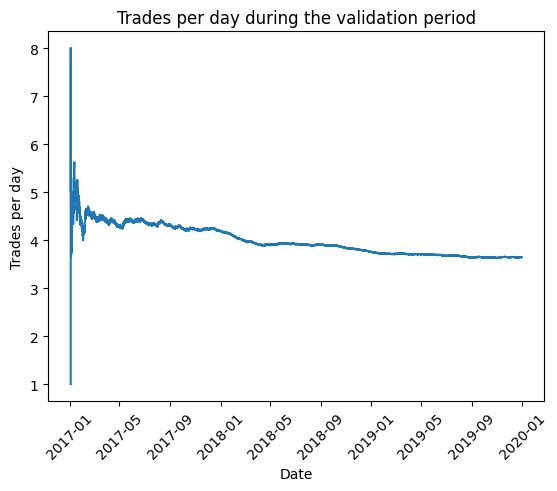

In [34]:
# Plot the trades per day during the validation period
trades_per_day_val = [x[5] for x in episodes_stats_val]
validation_dates = validation_dates[:len(trades_per_day_val)]
plt.plot(validation_dates, trades_per_day_val)
plt.xlabel('Date')
plt.ylabel('Trades per day')
plt.title('Trades per day during the validation period')
plt.xticks(rotation=45)
plt.show()

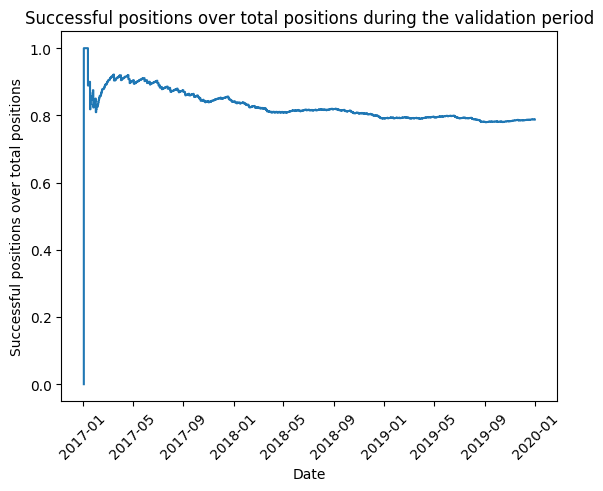

In [35]:
# Plot the successful positions over the total number of positions during the validation period
success_rate_val = [s[4] for s in episodes_stats_val]
plt.plot(validation_dates, success_rate_val)
plt.xlabel('Date')
plt.ylabel('Successful positions over total positions')
plt.title('Successful positions over total positions during the validation period')
plt.xticks(rotation=45)
plt.show()

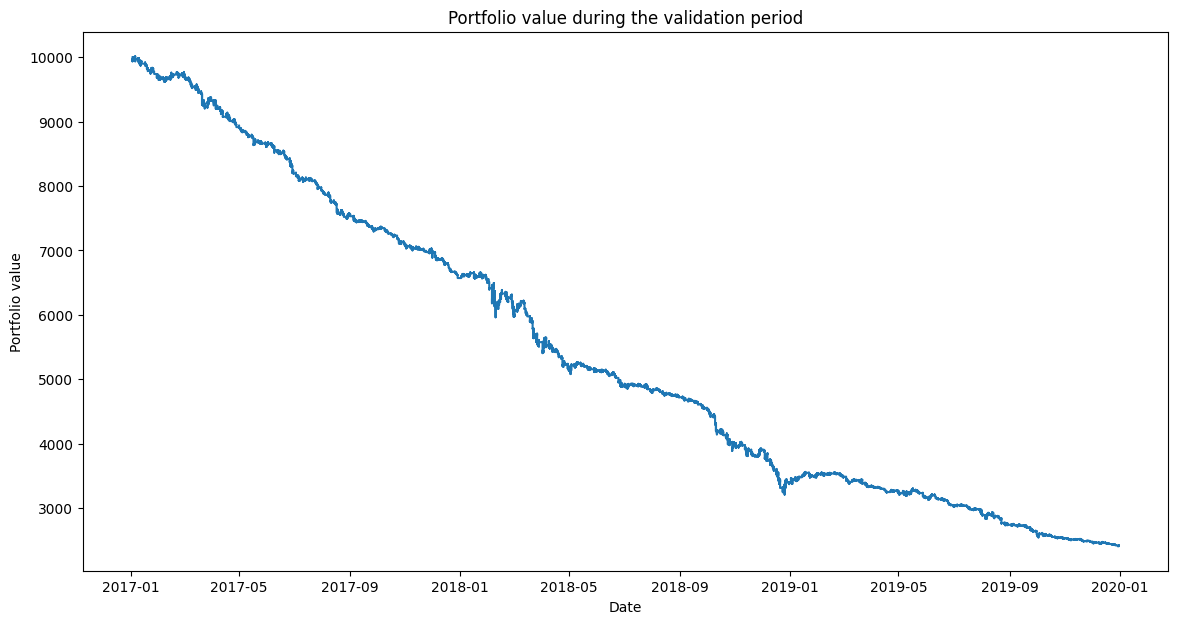

In [36]:
# Plot the portfolio value during the validation episode
# episodes_stats_val_array = np.array(episodes_stats_val)
net_worth_values_val = [x[8] for x in episodes_stats_val]
plt.figure(figsize=(14, 7))
plt.plot(validation_dates, net_worth_values_val)
plt.xlabel('Date')
plt.ylabel('Portfolio value')
plt.title('Portfolio value during the validation period')
plt.show()

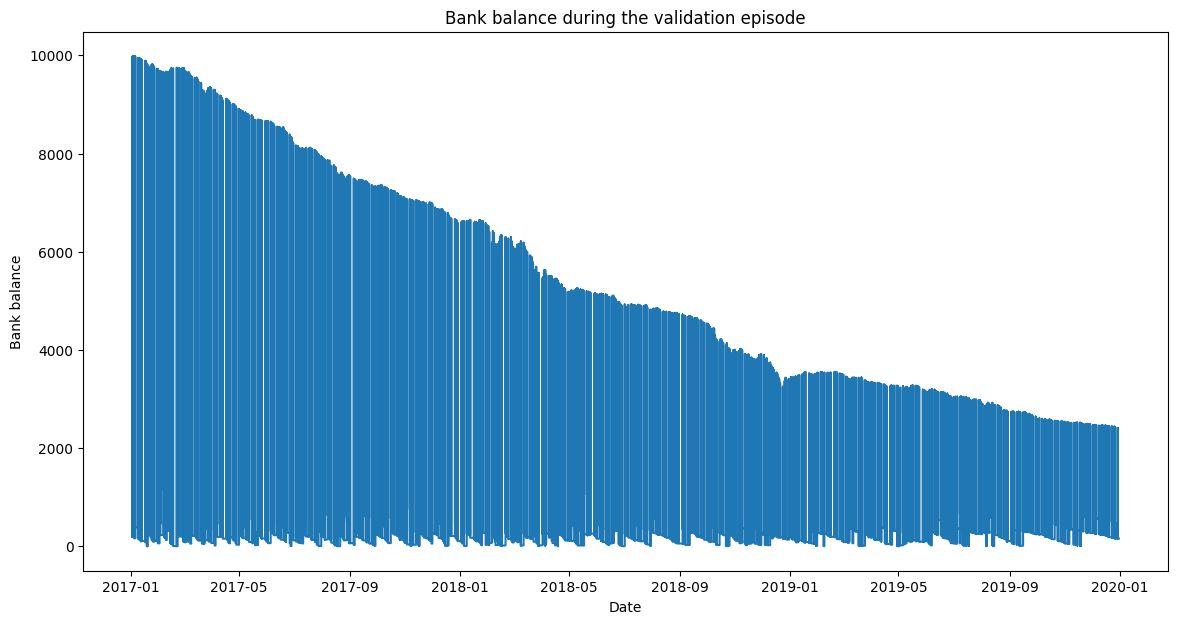

In [39]:
# Bank balance of the validation episode
bank_balance_val = [x[6] for x in episodes_stats_val]
# print(bank_balance_val)
plt.figure(figsize=(14, 7))
plt.plot(validation_dates, bank_balance_val)
plt.xlabel('Date')
plt.ylabel('Bank balance')
plt.title('Bank balance during the validation episode')
plt.show()

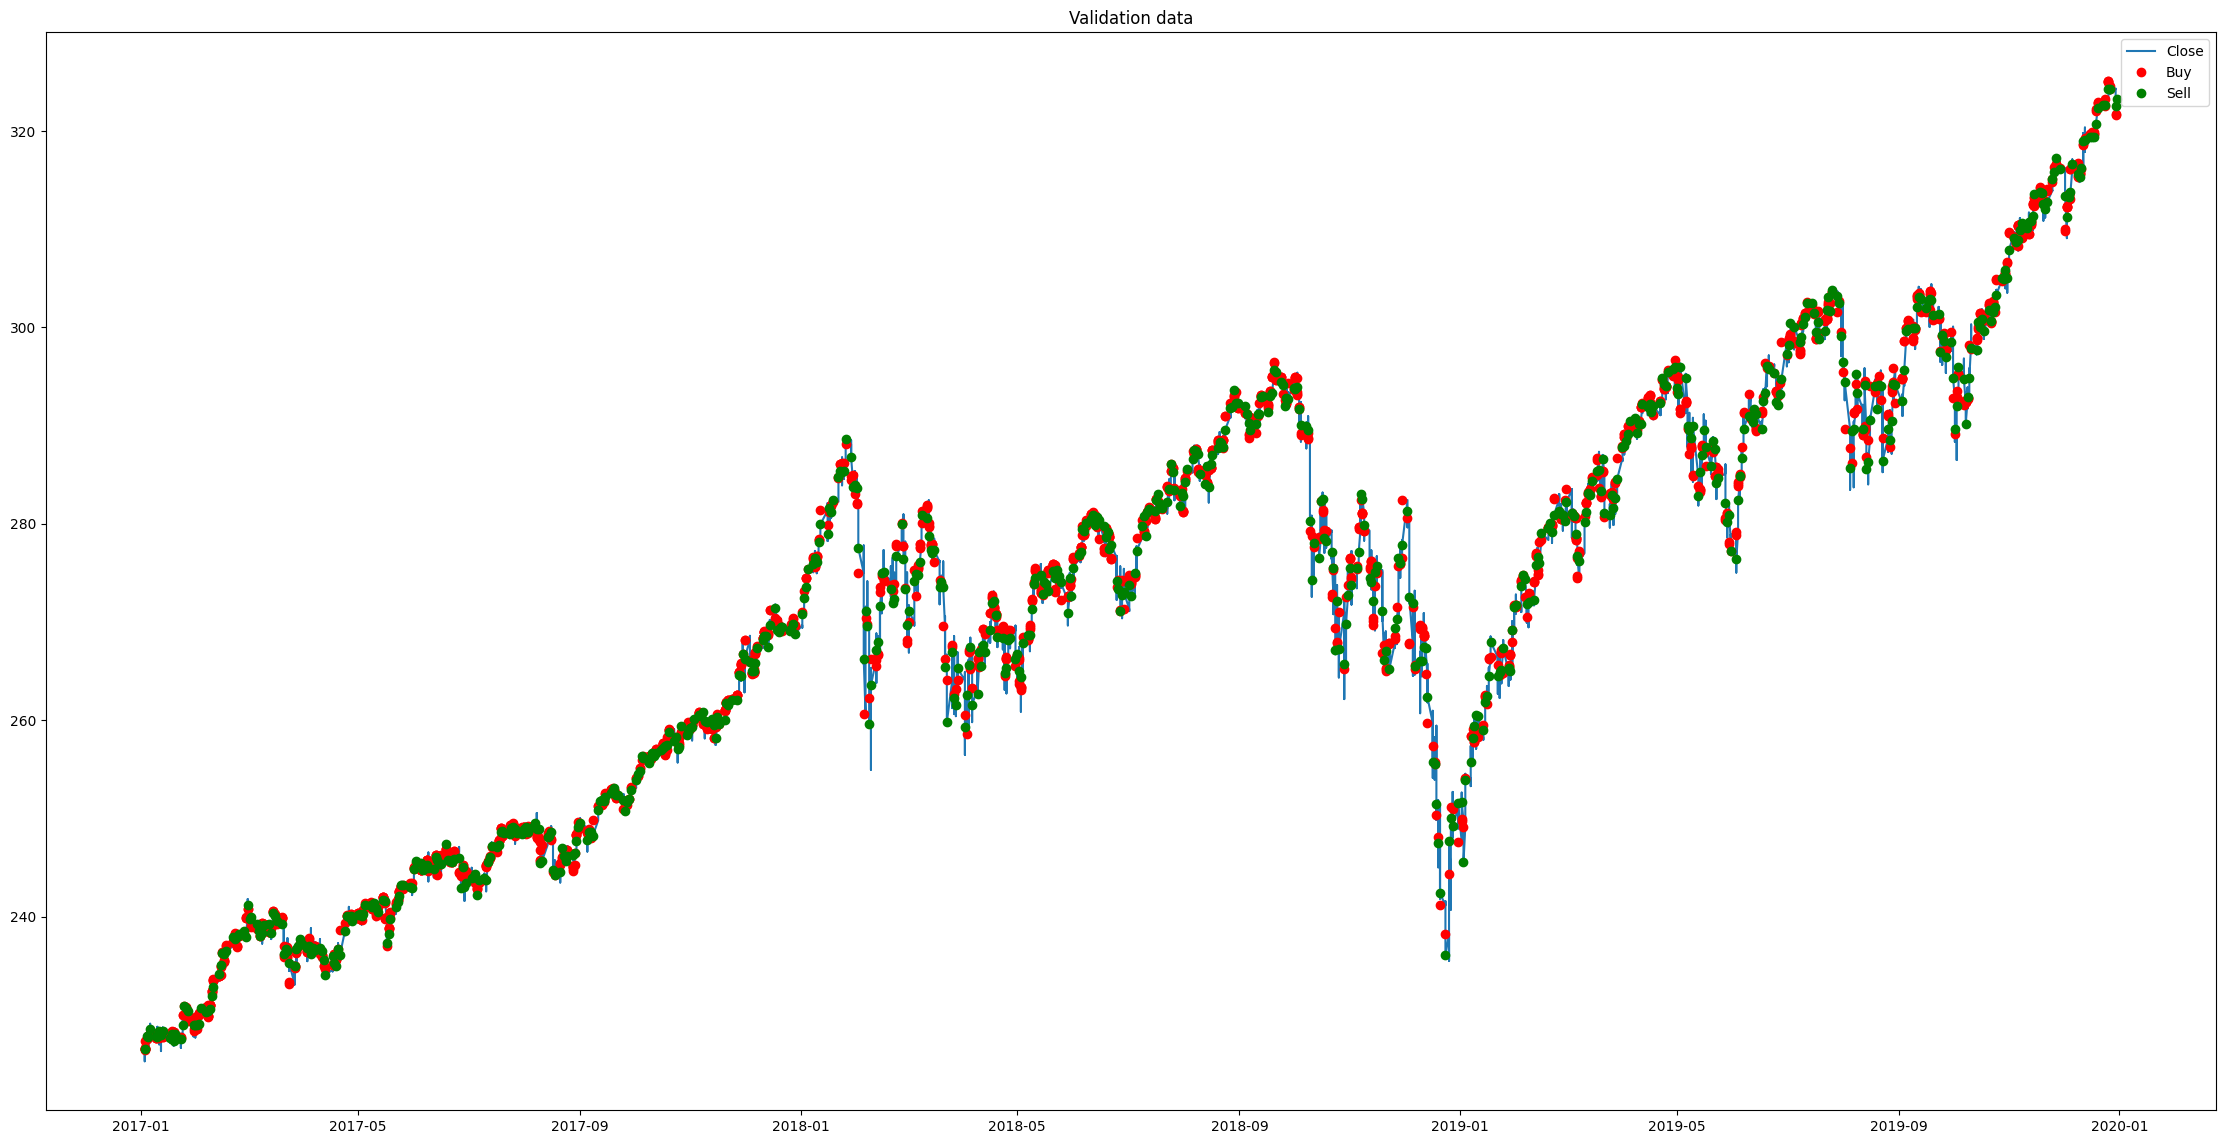

In [42]:
history_val = val_env.history
plt.figure(figsize=(28, 14))
plt.plot(validation_dates, df_val['Close'][:validation_dates.shape[0]], label='Close')
plt.plot(validation_dates, history_val['buy'][1:], 'ro', label='Buy')
plt.plot(validation_dates, history_val['sell'][1:], 'go', label='Sell')
plt.legend()
plt.title('Validation data')
plt.show()

## Conclusion and final remarks

This project had its difficulties, especially at the beginning. Our main challenge was figuring out how to use a reinforcement learning algorithm applied to the financial landscape. Looking at some examples and papers online we understood how to build the agent, the environment and how to approach this task.
In the end we learned a lot from this experience, we now understand how reinforcement learning can be applied in real-life situations. We are really happy after some struggles that our project can generate actual profits and respect all the requirements.


## Appendix: performance test (May 29th)